In [1]:
# To install missing libraries, use:
# import sys
# !{sys.executable} -m pip install \
#   earthpy \
#   geopandas \
# etc.

# Install pygbif for the GBIF download
# !pip install pygbif

# Install the latest version of dask
# conda install dask

# Import the below libraries:
# To create reproducible file paths
from pathlib import Path
import os

# To login to GBIF
from dotenv import load_dotenv
from getpass import getpass
# !pip install dotenv

# For the downloads
import csv
import requests
import tempfile
import time
import zipfile

# To work with different types of data
from glob import glob # To combine data arrays
from shapely.geometry import Point # To work with point geometries
import dask # To enable lazy loading
import earthpy # To work with "canned" data
import geopandas as gpd # To make GeoDataFrames/work with vector data
import pandas as pd # To work with dataframes
import pygbif.occurrences as occ
import pygbif.species as species
import numpy as np # To work with arrays
import rasterio # To read raster data
import rioxarray as rxr # To work with raster data
import xarray as xr # To work with data arrays
 
# For interactive plotting
from matplotlib.colors import LogNorm
import holoviews as hv
import hvplot.pandas 
import hvplot.xarray
import matplotlib.pyplot as plt
import panel as pn
import plotly.graph_objects as go

/usr/local/python/3.12.1/lib/python3.12/site-packages/earthpy/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# Create a directory to store the light pollution data in
lp_data_dir = Path("light-pollution-data-dir")
lp_data_dir.mkdir(parents=True, exist_ok=True)

# Establish the light pollution data URL
lp_url = "https://datapub.gfz-potsdam.de/download/10.5880.GFZ.1.4.2016.001/World_Atlas_2015.zip"
# Source: (Falchi et al., 2016)

# Create a path into the directory
lp_zip_path = Path(lp_data_dir/"World_Atlas_2015.zip")
lp_tif_path = Path(lp_data_dir/"World_Atlas_2015.tif")

# Download the data only once
if not lp_zip_path.exists():
     with requests.get(lp_url, stream=True) as r:
        r.raise_for_status()
        with open(lp_zip_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Extract the zip file only if the tif path does not exist
if not lp_tif_path.exists():
    with zipfile.ZipFile(lp_zip_path, 'r') as z:
        z.extractall(path=lp_data_dir)

In [3]:
# Delete the tpk file to save space

# Load the tif file as a data array from the disc
lp_da = rxr.open_rasterio(
    lp_tif_path,
    masked=True,
    chunks=1024, 
    cache=False
).squeeze()

# Define a bounding box for the boundary
bbox = [-125, 11, -50, 60]

# Clip the raster to the bounding box
americas_la_da = lp_da.rio.clip_box(*bbox)

# Downscale the raster
factor = 10
lp_da_small = americas_la_da.isel(
    x=slice(0, americas_la_da.sizes["x"], factor),
    y=slice(0, americas_la_da.sizes["y"], factor)
)

# Print the data array's crs and shape
print(lp_da_small.rio.crs, lp_da_small.shape)

EPSG:4326 (589, 901)


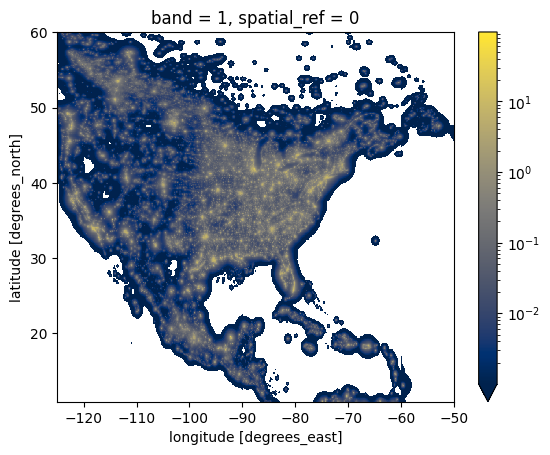

In [4]:
# Plot the light pollution data logarithmically
lp_log_plot = lp_da_small.plot(
    cmap="cividis",    
    norm=LogNorm(vmin=lp_da_small.min().values + 1e-3, vmax=lp_da_small.max().values)
)

In [5]:
# Create a directory to store the downloaded files in
shp_dir = Path("americas-shapefile-dir")
shp_dir.mkdir(parents=True, exist_ok=True)

# Cannot download from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries_lakes.zip using code due to a 406 client error
# Instead, manually download the zip file from the link and extract into the newly created directory

In [6]:
# Create a directory to store the boundary shapefile file in
shp_dir = Path("americas-shapefile-dir")
shp_dir.mkdir(parents=True, exist_ok=True)

# Establish the shape boundary data URL
shp_url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries_lakes.zip"
# Source: (Natural Earth, 2025)

# Create a path into the directory
shp_zip_path = Path("americas-shapefile-dir/ne_110m_admin_0_countries.zip")
shp_path = Path("americas-shapefile-dir/ne_110m_admin_0_countries.shp")

# Download the data only once
if not shp_path.exists():
     with requests.get(shp_url, stream=True) as r:
        r.raise_for_status()
        with open(shp_zip_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Extract the zip file only if the shp file does not exist
if not shp_path.exists():
    with zipfile.ZipFile(shp_zip_path, 'r') as z:
        z.extractall(path=shp_dir)

# Note: do not delete any of these files

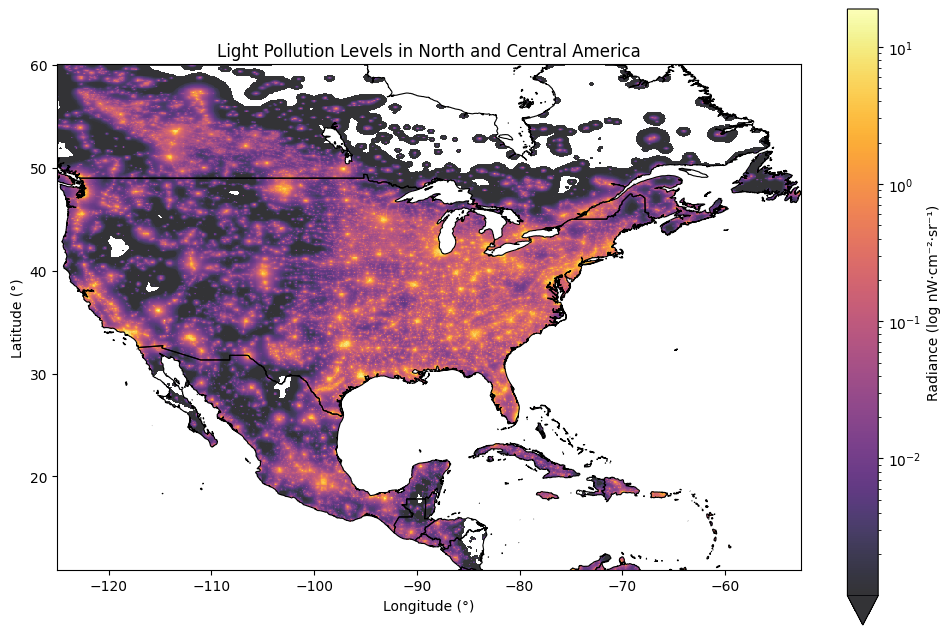

In [7]:
# Define the shapefile
countries = gpd.read_file("americas-shapefile-dir/ne_10m_admin_0_countries_lakes.shp")

# Reproject the file to match the crs of the light pollution raster
americas = countries.to_crs(lp_da_small.rio.crs)

# Clip from the disk
lp_americas_da = lp_da_small.rio.clip(americas.geometry, lp_da_small.rio.crs, drop=True, from_disk=True)

# Create a plot for the light pollution data array
fig, ax = plt.subplots(figsize=(12, 8))
lp_americas_plot = lp_americas_da.plot(
    ax=ax,
    cbar_kwargs={'label': 'Radiance (log nW·cm⁻²·sr⁻¹)'},
    cmap='inferno', 
    # Plot logarithmically 
    norm=LogNorm(vmin=lp_americas_da.min().values + 1e-3, vmax=lp_americas_da.max().values),
    alpha=0.8
)

# Set axis labels and title
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Light Pollution Levels in North and Central America")

# Overlay the boundary on the plot
americas.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Display the plot
plt.show()

In [8]:
# Save the light pollution plot as a png
lp_plot_path = Path("lp_plot.png")

if not lp_plot_path.exists():
    fig = lp_americas_plot.get_figure()
    fig.savefig("lp_plot.png", dpi=300, bbox_inches="tight")

In [9]:
# Create a directory to store the polyphemus moth occurrence data in
pm_data_dir = Path("polyphemus-moth-data-dir")
pm_data_dir.mkdir(parents=True, exist_ok=True)

In [10]:
# To avoid repeated login credential requests, manually create an .env file with your login credentials
load_dotenv()  

reset_credentials = False  

# Login into GBIF
# Securely request and store GBIF username, password, and email address
if ('GBIF_USER' not in os.environ) or reset_credentials:
    os.environ['GBIF_USER'] = input('GBIF username: ')

if ('GBIF_PWD' not in os.environ) or reset_credentials:
    os.environ['GBIF_PWD'] = getpass('GBIF password: ')

if ('GBIF_EMAIL' not in os.environ) or reset_credentials:
    os.environ['GBIF_EMAIL'] = input('GBIF email: ')

In [11]:
# Conduct a search query for the polyphemus moth
species_info = species.name_lookup('Antheraea polyphemus', rank='SPECIES')

# Obtain the first result
first_result = species_info['results'][0]

# List the species key
species_key = 1866570

# Print the results
first_result['species'], species_key

('Antheraea polyphemus', 1866570)

In [12]:
# Create paths
metadata_path = Path(pm_data_dir/"metadata.xml")
gbif_polyphemus_pattern = os.path.join(str(pm_data_dir), "**", "occurrence.txt")

# Only download the data once
if not metadata_path.exists():
    if not glob(gbif_polyphemus_pattern):
        if not 'GBIF_DOWNLOAD_KEY' in os.environ:
            # Submit query to GBIF
            gbif_query = occ.download([
                f"speciesKey = {species_key}",
                "hasCoordinate = True"
            ],
            # The DWCA format is necessary to obtain time and location data
            format="DWCA"
            )
            # Take the first result
            os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

        # Wait for the download to build
        dld_key = os.environ['GBIF_DOWNLOAD_KEY']
        wait = occ.download_meta(dld_key)['status']
        while not wait == 'SUCCEEDED':
            wait = occ.download_meta(dld_key)['status']
            time.sleep(5)

        # Download the GBIF data only once
        dld_info = occ.download_get(
            os.environ['GBIF_DOWNLOAD_KEY'],
            path=pm_data_dir
        )

# Define the dataframe
gbif_df = glob(gbif_polyphemus_pattern, recursive=True)

In [13]:
# Load the GBIF data
gbif_file = gbif_df[0]

gbif_polyphemus_df = pd.read_csv(
    gbif_file,
    delimiter='\t',
        index_col='gbifID',
        usecols=['gbifID', 'eventDate','decimalLatitude', 'decimalLongitude']
)
gbif_polyphemus_df

,eventDate,decimalLatitude,decimalLongitude
gbifID,,,
923926047,2014-07-01T19:26:19,30.076778,-95.495178
923925493,2014-07-01T04:53:34,43.852963,-72.588778
923925071,2014-06-30T13:58:01,43.599196,-72.517297
923924387,2014-06-28T22:35:38,43.852963,-72.588778
923923819,2014-06-26T22:01:11,35.544423,-82.370604
...,...,...,...
1024184645,2014-07-02,44.285028,-72.573667
1024184438,2014-07-04T15:03:36,43.562679,-72.496800
1024182752,2014-06-11T12:38:08,46.137070,-89.891541


In [14]:
# Extract the month and year
gbif_polyphemus_df['eventDate'] = pd.to_datetime(gbif_polyphemus_df['eventDate'], errors='coerce')
gbif_polyphemus_df['month'] = gbif_polyphemus_df['eventDate'].dt.month
gbif_polyphemus_df['year'] = gbif_polyphemus_df['eventDate'].dt.year

#  Combine month and year into a single column
gbif_polyphemus_df['Date'] = gbif_polyphemus_df['eventDate'].dt.to_period('M')

gbif_polyphemus_df.head()

,eventDate,decimalLatitude,decimalLongitude,month,year,Date
gbifID,,,,,,
923926047,2014-07-01 19:26:19,30.076778,-95.495178,7.0,2014.0,2014-07
923925493,2014-07-01 04:53:34,43.852963,-72.588778,7.0,2014.0,2014-07
923925071,2014-06-30 13:58:01,43.599196,-72.517297,6.0,2014.0,2014-06
923924387,2014-06-28 22:35:38,43.852963,-72.588778,6.0,2014.0,2014-06
923923819,2014-06-26 22:01:11,35.544423,-82.370604,6.0,2014.0,2014-06


In [15]:
# Convert the GBIF data to a GeoDataFrame
# Input the longitude and latitude column names
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_polyphemus_df, 
        geometry=gpd.points_from_xy(
            gbif_polyphemus_df.decimalLongitude, 
            gbif_polyphemus_df.decimalLatitude), 
        crs="EPSG:4326")
    # Specify the desired columns
    [['Date', 'geometry', 'decimalLongitude', 'decimalLatitude']]
)
gbif_gdf

,Date,geometry,decimalLongitude,decimalLatitude
gbifID,,,,
923926047,2014-07,POINT (-95.49518 30.07678),-95.495178,30.076778
923925493,2014-07,POINT (-72.58878 43.85296),-72.588778,43.852963
923925071,2014-06,POINT (-72.5173 43.5992),-72.517297,43.599196
923924387,2014-06,POINT (-72.58878 43.85296),-72.588778,43.852963
923923819,2014-06,POINT (-82.3706 35.54442),-82.370604,35.544423
...,...,...,...,...
1024184645,NaT,POINT (-72.57367 44.28503),-72.573667,44.285028
1024184438,2014-07,POINT (-72.4968 43.56268),-72.496800,43.562679
1024182752,2014-06,POINT (-89.89154 46.13707),-89.891541,46.137070


In [16]:
# Remove data points with "NaT" values 
clean_gbif_gdf = gbif_gdf.dropna(subset=['Date'])

clean_gbif_gdf

,Date,geometry,decimalLongitude,decimalLatitude
gbifID,,,,
923926047,2014-07,POINT (-95.49518 30.07678),-95.495178,30.076778
923925493,2014-07,POINT (-72.58878 43.85296),-72.588778,43.852963
923925071,2014-06,POINT (-72.5173 43.5992),-72.517297,43.599196
923924387,2014-06,POINT (-72.58878 43.85296),-72.588778,43.852963
923923819,2014-06,POINT (-82.3706 35.54442),-82.370604,35.544423
...,...,...,...,...
1024192518,2014-07,POINT (-73.17825 43.60925),-73.178253,43.609253
1024184438,2014-07,POINT (-72.4968 43.56268),-72.496800,43.562679
1024182752,2014-06,POINT (-89.89154 46.13707),-89.891541,46.137070


In [17]:
# Plot the points to ensure they were processed properly
clean_gbif_gdf.hvplot(
    x="decimalLongitude",
    y="decimalLatitude",
    geo=True,
    crs="EPSG:4326",
    tiles="CartoLight",
    title=f'Recorded Polyphemus Moth Sightings Between July 1996 and November 2025',
    frame_height=400,
    frame_width=800,
)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [decimalLongitude,decimalLatitude]

In [18]:
# Prepare the "Date" column
clean_gbif_gdf['Date'] = clean_gbif_gdf['Date'].astype(str).str.slice(0,7)
clean_gbif_gdf['decimalLatitude'] = clean_gbif_gdf['decimalLatitude'].astype(float)
clean_gbif_gdf['decimalLongitude'] = clean_gbif_gdf['decimalLongitude'].astype(float)

# Set the parameters for the slider wdget
date_options = sorted(clean_gbif_gdf['Date'].unique())
date_slider = pn.widgets.DiscreteSlider(name='Date (YYYY-MM)', options=list(date_options), value=date_options[0])

# Set the plot bounds so they do not change with the slider
xmin, ymin, xmax, ymax = clean_gbif_gdf.total_bounds

# Create the plot
def plot_date(date):
    df = clean_gbif_gdf[clean_gbif_gdf['Date'] == date]
    return df.hvplot.points(
        x='decimalLongitude',
        y='decimalLatitude',
        geo=True,
        tiles='CartoLight',
        color='blue',
        size=8,
        alpha=0.6,
        title=f'Polyphemus Moth Sightings',
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        frame_height=600,
        frame_width=400
    )

# Define the plot
pm_plot = pn.bind(plot_date, date_slider)

# Define the widget layout
pn.Column(
    pn.Spacer(height=10),
    pm_plot,
    pn.layout.FlexBox(date_slider, justify_content='left')
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

BokehModel(combine_events=True, render_bundle={'docs_json': {'75db281b-1c8e-4f42-be99-7b399779eb99': {'version…

In [19]:
# Define the parameters of the layout for the html
pm_gdif_plot = pn.Column(
    pn.Spacer(height=10),
    pm_plot,
    pn.layout.FlexBox(date_slider, justify_content="left")
)

# Save the plot as an interactive html
pm_plot_path = Path("pm_plot.html")   

if not pm_plot_path.exists():
    pm_gdif_plot.save(
        pm_plot_path,
        embed=True,
        resources="cdn"
    )

In [20]:
# Prepare a clean copy of the occurrence data
overlay_gdf = clean_gbif_gdf.copy()
overlay_gdf["Date"] = overlay_gdf["Date"].astype(str).str.slice(0, 7)
overlay_gdf["decimalLatitude"] = overlay_gdf["decimalLatitude"].astype(float)
overlay_gdf["decimalLongitude"] = overlay_gdf["decimalLongitude"].astype(float)
overlay_gdf = overlay_gdf.dropna(subset=["decimalLatitude", "decimalLongitude", "Date"])

# Define the slider options so they are in chronological order
date_options = sorted(overlay_gdf["Date"].unique())

date_slider_final = pn.widgets.DiscreteSlider(
    name="Date (YYYY-MM)",
    options=list(date_options),
    value=date_options[0]
)

def lp_pm_overlay(date):
    # Decrease the figure size so the color bar is visible
    fig, ax = plt.subplots(figsize=(7, 4))

    # Use the final light pollution map as the background for the overlay
    lp_americas_da.plot(
        ax=ax,
        cbar_kwargs={"label": "Radiance (log nW·cm⁻²·sr⁻¹)"},
        cmap="inferno",
        norm=LogNorm(
            vmin=lp_americas_da.min().values + 1e-3,
            vmax=lp_americas_da.max().values
        ),
        alpha=0.8
    )

    # Apply the created boundary
    americas.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

    # Use the "Date" column's data in the overlay
    subset = overlay_gdf[overlay_gdf["Date"] == date]

    # Use the scatter function to define the x and y values for the occurrence points
    ax.scatter(
        subset["decimalLongitude"].values,
        subset["decimalLatitude"].values,
        s=30,
        edgecolor="black",
        linewidth=0.4,
        alpha=0.95,
        zorder=10_000
    )

    # Create labels for the tile and axes
    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Latitude (°)")
    ax.set_title(f"Polyphemus Moth Sightings as Correlated with Light Pollution Levels")

    # Prevent duplicate static figures from appearing
    plt.close(fig)

    return fig

# Bind the slider to plot
lp_pm_plot_interface = pn.bind(lp_pm_overlay, date=date_slider_final)

# Define the final layout 
lp_pm_plot = pn.Column(
    lp_pm_plot_interface,
    date_slider_final
)

# Display the plot
lp_pm_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'0b83158e-ac74-4d6f-ac6b-c4d33bb6e185': {'version…

In [21]:
# Save the plot as an interactive html
lp_pm_plot_path = Path("lp_pm_plot.html")   

if not lp_pm_plot_path.exists():
    lp_pm_plot.save(
        lp_pm_plot_path,
        embed=True,
        resources="cdn"
    )

<u>Introduction</u>

The proverb “drawn like a moth to a flame” refers to an inexplicable attraction to something harmful—dangerous, even. The phrase originates from the observation that moths appear to be attracted to artificial light. In actuality, artificial light interferes with a navigation strategy known as transverse orientation, in which insects keep at a fixed angle to a distant celestial body to fly in a straight line (DeSouza, 2019). Moths cannot distinguish artificial light from the light of these celestial bodies, causing disorientation and increasing mortality. Larger moths are speculated to be more attracted to light—and thus, more susceptible to light pollution—due to their increased eye size (Boyes et al., 2021). Among all macro-moths, the polyphemus moth (*Antheraea polyphemus*)  is among the most well documented species on sites like iNaturalist. At present, there is insufficient evidence to conclude that light pollution universally impacts all moth species at the population level (Boyes et al., 2021), partially attributable to a lack of thorough spatiotemporal population data (Kalinkat et al., 2021). Examining the relationship between light pollution levels and recorded population densities of a well documented species like the polyphemus moth is an integral first step in establishing what impact—if any—light pollution has on moth population densities.

<u>Methods</u>

Three downloadable datasets were used in this project: the New World Atlas of Artificial Sky Brightness (Falchi et al., 2016), New Earth's country boundaries without boundary lakes (Natural Earth, 2025), and all polyphemus moth sightings recorded on GBIF (GBIF, 2025). Within the code, two measures were taken to avoid crashes: the downloads were streamed or put on the disk, and data was only downloaded once.

<u>Results and Discussion</u>